In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [6]:
train = tf.data.Dataset.from_tensor_slices(tensors=(x_train,y_train))
test = tf.data.Dataset.from_tensor_slices(tensors=(x_test,y_test))

In [7]:
train_iterator = train.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

# Plot images

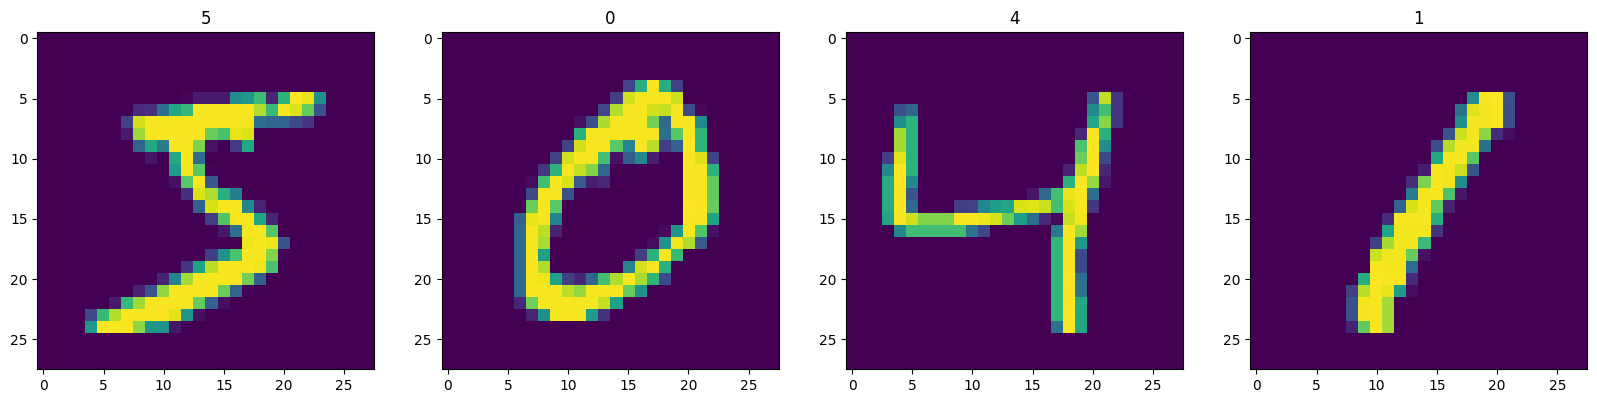

In [8]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = train_iterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample[0]))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample[1])

In [9]:
# Scale and return images only 
def scale_images(image, label): 
    return image / 255.0 , label

In [10]:
# Running the dataset through the scale_images preprocessing step
train_ds = train.map(scale_images) 
# Cache the dataset for that batch , shuffle , batch , prefectch
train_ds = train_ds.cache().shuffle(60000).batch(128).prefetch(64)

test_ds = test.map(scale_images) 
# Cache the dataset for that batch , shuffle , batch , prefectch
test_ds = test_ds.cache().shuffle(60000).batch(128).prefetch(64)

# Generator

In [25]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [29]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [32]:
generator = build_generator()

In [33]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

In [53]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 20ms/step


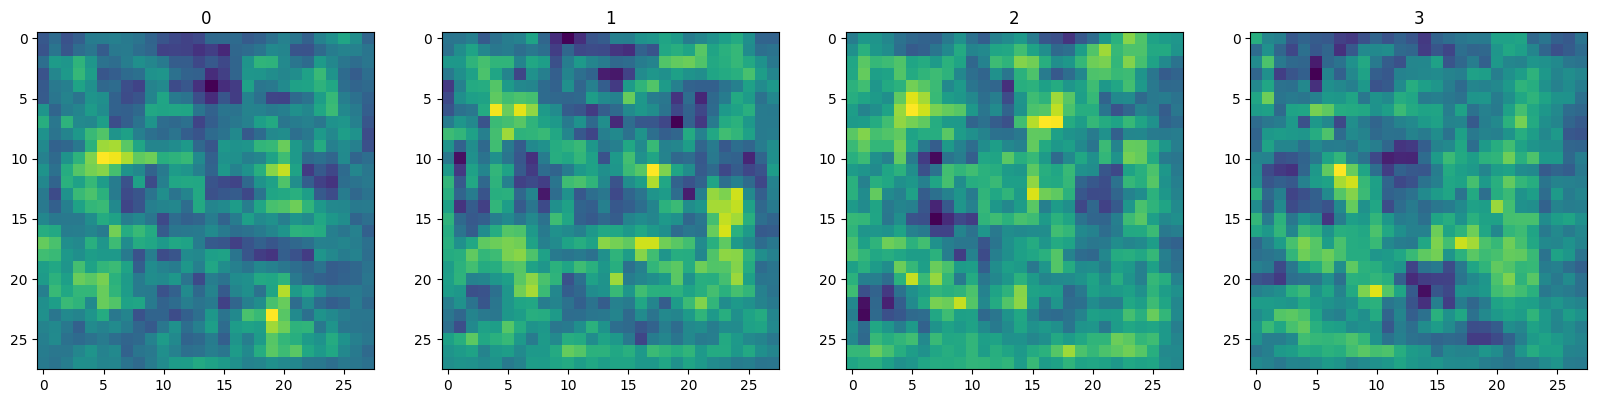

In [54]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, image in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(image))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

# Discriminator

In [46]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [47]:
discriminator = build_discriminator()

In [48]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)      

In [55]:
img = img[0]
img.shape

(28, 28, 1)

In [ ]:
discriminator.predict(img)

In [57]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()